# GBDT

<ol>
    <li>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)

sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [ ]:
#please use below code to load glove vectors 
import pickle
with open('shared_drive/aaic/11_Donors_choose_GBDT/glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [ ]:
import pandas as pd
data = pd.read_csv('shared_drive/aaic/6_Donors_choose_NB/preprocessed_data.csv')

In [ ]:
#data=data[:500]

In [ ]:
from tqdm import tqdm
sentiment={'neg':[],'neu':[],'pos':[],'compound':[]}
for i in tqdm(data['essay'].values):
  temp=sid.polarity_scores(i)
  sentiment['neg'].append(temp['neg'])
  sentiment['neu'].append(temp['neu'])
  sentiment['pos'].append(temp['pos'])
  sentiment['compound'].append(temp['compound'])

100%|██████████| 109248/109248 [02:29<00:00, 730.53it/s]


In [ ]:
sentiment=pd.DataFrame(sentiment)
data=pd.concat([data,sentiment],axis=1)

In [ ]:
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,neg,neu,pos,compound
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05,0.013,0.783,0.205,0.9867
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03,0.072,0.680,0.248,0.9897
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00,0.017,0.721,0.262,0.9860
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04,0.030,0.783,0.187,0.9524
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74,0.029,0.683,0.288,0.9873


In [ ]:
len(data)

109248

In [ ]:
X=data.drop('project_is_approved',axis=1)
y=data['project_is_approved'].values

In [ ]:
data.project_is_approved.value_counts()

1    92706
0    16542
Name: project_is_approved, dtype: int64

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=10)

In [ ]:
x_train.shape,y_train.shape

((81936, 12), (81936,))

In [ ]:
x_test.shape,y_test.shape

((27312, 12), (27312,))

<h2>1.3 Make Data Model Ready: encoding eassay, and project_title</h2>

In [ ]:

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer=TfidfVectorizer()
x_train_essay=vectorizer.fit_transform(x_train['essay'])
x_test_essay=vectorizer.transform(x_test['essay'])
dictionary = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())

/home/ubuntu/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
x_train_essay.shape

(81936, 50413)

In [ ]:
x_test_essay.shape

(27312, 50413)

<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [ ]:

x_train_price=x_train['price'].values.reshape(-1,1)  # not normalizing data , because DT not use distances
x_test_price=x_test['price'].values.reshape(-1,1)
x_train_teacher_number_of_previously_posted_projects=x_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
x_test_teacher_number_of_previously_posted_projects=x_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)
x_train_neg=x_train['neg'].values.reshape(-1,1)
x_test_neg=x_test['neg'].values.reshape(-1,1)
x_train_pos=x_train['pos'].values.reshape(-1,1)
x_test_pos=x_test['pos'].values.reshape(-1,1)
x_train_neu=x_train['neu'].values.reshape(-1,1)
x_test_neu=x_test['neu'].values.reshape(-1,1)
x_train_compound=x_train['compound'].values.reshape(-1,1)
x_test_compound=x_test['compound'].values.reshape(-1,1)

In [ ]:
def response_coding(feature_data,label_data,x_test):  #features data = data of the feature which need to do response coding  #lebel_data = Y values ,x_test = test data for that feature 
    data=pd.DataFrame({'x':feature_data,'y':label_data})
    temp=data['x'].value_counts()
    class_1=data[data['y']==0].drop('y',axis=1)
    temp1=class_1.value_counts()
    class_2=data[data['y']==1].drop('y',axis=1)
    temp2=class_2.value_counts()
    column_1=[]
    column_2=[]
    for i in feature_data:
        try:
            column_1.append(temp1[i]/temp[i])
        except:
            temp1[i]=0             #if its not present in one class giving value 0   
            column_1.append(0)
        try:
            column_2.append(temp2[i]/temp[i])
        except:
            temp2[i]=0             #if its not present in one class giving value 0
            column_2.append(0)
    x_train_x=pd.DataFrame({'0':column_1,'1':column_2})
    column_1=[]
    column_2=[]
    for i in x_test.values:
        try:
            column_1.append(temp1[i]/temp[i])
            column_2.append(temp2[i]/temp[i])
        except:
            column_1.append(0.5)   #if not present in the train data giving 0.5
            column_2.append(0.5)
    x_test_x=pd.DataFrame({'0':column_1,'1':column_2})
    return x_train_x,x_test_x  #x_train and x_test

In [ ]:
x_train_school_state,x_test_school_state=response_coding(x_train['school_state'].values,y_train,x_test['school_state'])
x_train_teacher_prefix,x_test_teacher_prefix=response_coding(x_train['teacher_prefix'].values,y_train,x_test['teacher_prefix'])
x_train_project_grade_category,x_test_project_grade_category=response_coding(x_train['project_grade_category'].values,y_train,x_test['project_grade_category'])
x_train_clean_subcategories,x_test_clean_subcategories=response_coding(x_train['clean_subcategories'].values,y_train,x_test['clean_subcategories'])
x_train_clean_categories,x_test_clean_categories=response_coding(x_train['clean_categories'].values,y_train,x_test['clean_categories'])

In [ ]:
from scipy.sparse import hstack

In [ ]:
x_test_school_state.shape

(27312, 2)

# Set-1

In [ ]:
x_train_final=hstack([x_train_school_state.values,x_train_teacher_prefix.values,x_train_project_grade_category.values,x_train_clean_categories.values,x_train_clean_subcategories.values,x_train_price,x_train_teacher_number_of_previously_posted_projects,x_train_essay,x_train_neg,x_train_neu,x_train_pos,x_train_compound])
x_test_final=hstack([x_test_school_state.values,x_test_teacher_prefix.values,x_test_project_grade_category.values,x_test_clean_categories.values,x_test_clean_subcategories.values,x_test_price,x_test_teacher_number_of_previously_posted_projects,x_test_essay,x_test_neg,x_test_neu,x_test_pos,x_test_compound])

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
x_train_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_train['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_train_tfidf_w2v_vectors.append(vector)
print()
print(len(x_train_tfidf_w2v_vectors))
print(len(x_train_tfidf_w2v_vectors[0]))

100%|██████████| 81936/81936 [02:29<00:00, 548.83it/s]


81936
300


In [ ]:
# average Word2Vec
# compute average word2vec for each review.
x_test_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(x_test['essay'].values): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    x_test_tfidf_w2v_vectors.append(vector)
print()
print(len(x_test_tfidf_w2v_vectors))
print(len(x_test_tfidf_w2v_vectors[0]))

100%|██████████| 27312/27312 [00:49<00:00, 556.77it/s]


27312
300


In [ ]:
from scipy.sparse import coo_matrix

In [ ]:
x_train_tfidf_w2v_vectors=coo_matrix(np.array(x_train_tfidf_w2v_vectors))
x_test_tfidf_w2v_vectors=coo_matrix(np.array(x_test_tfidf_w2v_vectors))

In [ ]:
x_train_tfidf_w2v_vectors.shape

(81936, 300)

# Set-2

In [ ]:
x_train_final_set2=hstack([x_train_school_state.values,x_train_teacher_prefix.values,x_train_project_grade_category.values,x_train_clean_categories.values,x_train_clean_subcategories.values,x_train_price,x_train_teacher_number_of_previously_posted_projects,x_train_tfidf_w2v_vectors])
x_test_final_set2=hstack([x_test_school_state.values,x_test_teacher_prefix.values,x_test_project_grade_category.values,x_test_clean_categories.values,x_test_clean_subcategories.values,x_test_price,x_test_teacher_number_of_previously_posted_projects,x_test_tfidf_w2v_vectors])

<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

# model-1

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis 
from xgboost import XGBClassifier
model = XGBClassifier(random_state=10)

/home/ubuntu/.local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [ ]:
from sklearn.model_selection import GridSearchCV
paras={'n_estimators':[100,150,200,250],'max_depth':[2,3,4]}
model_1=GridSearchCV(model,param_grid=paras,scoring='roc_auc',return_train_score=True,cv=10,n_jobs=-1)

In [ ]:
x_train_final.shape

(81936, 50429)

In [ ]:
model_1.fit(x_train_final,y_train)

/home/ubuntu/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:59:36] WARNING: /workspace/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=10, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=

In [ ]:
model_1.best_params_

{'max_depth': 2, 'n_estimators': 250}

In [ ]:
train_map=pd.DataFrame(data=model_1.cv_results_['mean_train_score'].reshape(3,4),index=paras['max_depth'],columns=paras['n_estimators'])
test_map=pd.DataFrame(data=model_1.cv_results_['mean_test_score'].reshape(3,4),index=paras['max_depth'],columns=paras['n_estimators'])

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

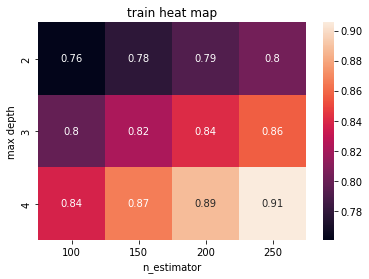

In [ ]:
sns.heatmap(train_map,annot=True)
plt.xlabel('n_estimator')
plt.ylabel('max depth')
plt.title('train heat map')
plt.show()

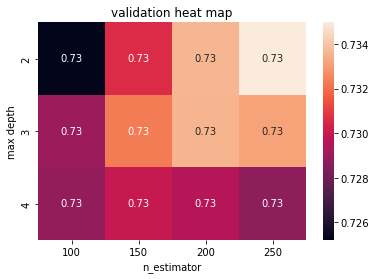

In [ ]:
sns.heatmap(test_map,annot=True)
plt.xlabel('n_estimator')
plt.ylabel('max depth')
plt.title('validation heat map')
plt.show()

In [ ]:
model_1.best_params_

{'max_depth': 2, 'n_estimators': 250}

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=model_1.best_params_['n_estimators'],max_depth=model_1.best_params_['max_depth'],random_state=10)
model.fit(x_train_final,y_train)

/home/ubuntu/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:57] WARNING: /workspace/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
predict_train=model.predict_proba(x_train_final)
predict_train=predict_train.T[1].T
predict_test=model.predict_proba(x_test_final)
predict_test=predict_test.T[1].T

In [ ]:
print("accuracy on training data {} ".format(model.score(x_train_final,y_train)))
print("accuracy on test data {} ".format(model.score(x_test_final,y_test)))

accuracy on training data 0.855472563952353 
accuracy on test data 0.8515304628002344 


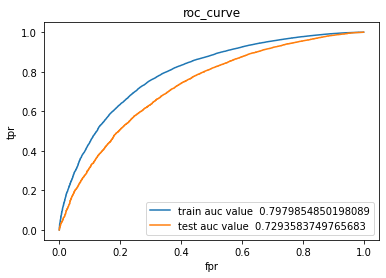

In [ ]:
from sklearn.metrics import roc_curve,auc
import numpy as np
fpr,tpr,thres=roc_curve(y_train,predict_train)
plt.plot(fpr,tpr,label='train auc value  {}'.format(auc(fpr,tpr)))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
#plt.title('roc_curve for train')
fpr,tpr,thres=roc_curve(y_test,predict_test)
plt.plot(fpr,tpr,label='test auc value  {}'.format(auc(fpr,tpr)))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('roc_curve')
plt.show()

best threshold

In [ ]:
def best_threshold(fpr,tpr,thres):
    return thres[np.argmax(tpr*(1-fpr))]
def after_best_threshold(x,thres):
    label=[ ]
    for i in x:
        if i<thres:
            label.append(0)
        else:
            label.append(1)
    return label

In [ ]:
predict_train.max()

0.9978115

In [ ]:
fpr,tpr,thres=roc_curve(y_train,predict_train)
b=best_threshold(fpr,tpr,thres)

In [ ]:
from sklearn.metrics import confusion_matrix
predict_train_after_best_thresh=after_best_threshold(predict_train,b)
predict_test_after_best_thresh=after_best_threshold(predict_test,b)

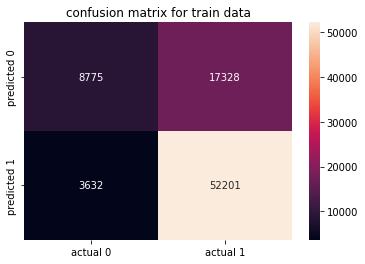

In [ ]:
cm=confusion_matrix(y_train,predict_train_after_best_thresh).T
temp=pd.DataFrame(data=cm,columns=['actual 0','actual 1'],index=['predicted 0','predicted 1'])
sns.heatmap(temp,annot=True,fmt='d')
plt.title('confusion matrix for train data')
plt.show()

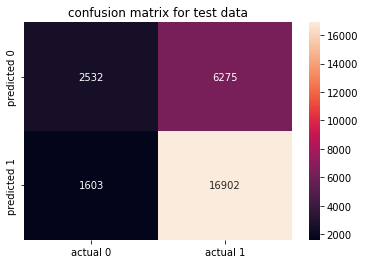

In [ ]:
cm=confusion_matrix(y_test,predict_test_after_best_thresh).T
temp=pd.DataFrame(data=cm,columns=['actual 0','actual 1'],index=['predicted 0','predicted 1'])
sns.heatmap(temp,annot=True,fmt='d')
plt.title('confusion matrix for test data')
plt.show()

# model-2

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis 
from xgboost import XGBClassifier
model = XGBClassifier(random_state=10)

In [ ]:
from sklearn.model_selection import GridSearchCV
paras={'n_estimators':[100,150,200,250],'max_depth':[2,3,4]}
model_1=GridSearchCV(model,param_grid=paras,scoring='roc_auc',return_train_score=True,cv=10,n_jobs=-1)

In [ ]:
model_1.fit(x_train_final_set2,y_train)

/home/ubuntu/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:53] WARNING: /workspace/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=10, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=

In [ ]:
model_1.best_params_

{'max_depth': 2, 'n_estimators': 200}

In [ ]:
train_map=pd.DataFrame(data=model_1.cv_results_['mean_train_score'].reshape(3,4),index=paras['max_depth'],columns=paras['n_estimators'])
test_map=pd.DataFrame(data=model_1.cv_results_['mean_test_score'].reshape(3,4),index=paras['max_depth'],columns=paras['n_estimators'])

In [ ]:
train_map

,100,150,200,250
2,0.747299,0.760961,0.772109,0.781827
3,0.786120,0.809445,0.829814,0.847021
4,0.838840,0.873382,0.900610,0.922188


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

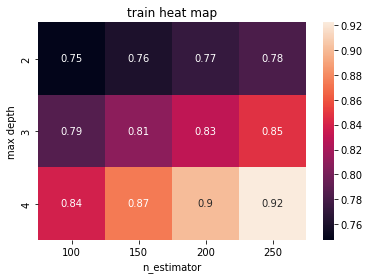

In [ ]:
sns.heatmap(train_map,annot=True)
plt.xlabel('n_estimator')
plt.ylabel('max depth')
plt.title('train heat map')
plt.show()

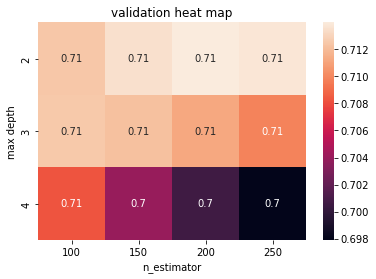

In [ ]:
sns.heatmap(test_map,annot=True)
plt.xlabel('n_estimator')
plt.ylabel('max depth')
plt.title('validation heat map')
plt.show()

In [ ]:
model_1.best_params_

{'max_depth': 2, 'n_estimators': 200}

In [ ]:
from xgboost import XGBClassifier
model = XGBClassifier(n_estimators=model_1.best_params_['n_estimators'],max_depth=model_1.best_params_['max_depth'],random_state=10)
model.fit(x_train_final_set2,y_train)

/home/ubuntu/.local/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:39:24] WARNING: /workspace/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
predict_train=model.predict_proba(x_train_final_set2)
predict_train=predict_train.T[1].T
predict_test=model.predict_proba(x_test_final_set2)
predict_test=predict_test.T[1].T

In [ ]:
print("accuracy on training data {} ".format(model.score(x_train_final_set2,y_train)))
print("accuracy on test data {} ".format(model.score(x_test_final_set2,y_test)))

accuracy on training data 0.8538493458308924 
accuracy on test data 0.8499926772114821 


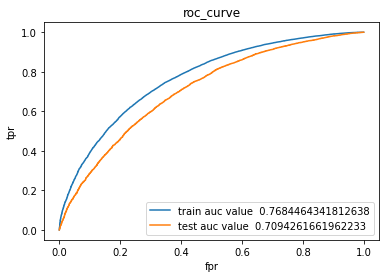

In [ ]:
from sklearn.metrics import roc_curve,auc
import numpy as np
fpr,tpr,thres=roc_curve(y_train,predict_train)
plt.plot(fpr,tpr,label='train auc value  {}'.format(auc(fpr,tpr)))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
#plt.title('roc_curve for train')
fpr,tpr,thres=roc_curve(y_test,predict_test)
plt.plot(fpr,tpr,label='test auc value  {}'.format(auc(fpr,tpr)))
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.title('roc_curve')
plt.show()

In [ ]:
def best_threshold(fpr,tpr,thres):
    return thres[np.argmax(tpr*(1-fpr))]
def after_best_threshold(x,thres):
    label=[ ]
    for i in x:
        if i<thres:
            label.append(0)
        else:
            label.append(1)
    return label

In [ ]:
fpr,tpr,thres=roc_curve(y_train,predict_train)
b=best_threshold(fpr,tpr,thres)

In [ ]:
from sklearn.metrics import confusion_matrix
predict_train_after_best_thresh=after_best_threshold(predict_train,b)
predict_test_after_best_thresh=after_best_threshold(predict_test,b)

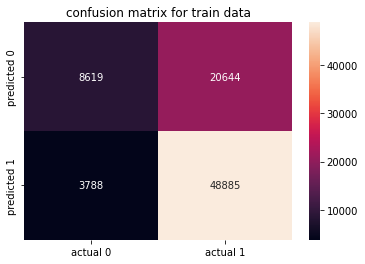

In [ ]:
cm=confusion_matrix(y_train,predict_train_after_best_thresh).T
temp=pd.DataFrame(data=cm,columns=['actual 0','actual 1'],index=['predicted 0','predicted 1'])
sns.heatmap(temp,annot=True,fmt='d')
plt.title('confusion matrix for train data')
plt.show()

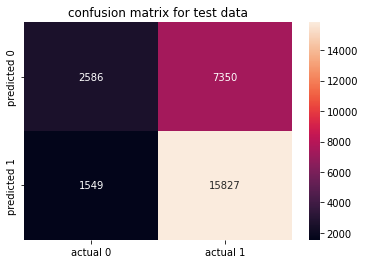

In [ ]:
cm=confusion_matrix(y_test,predict_test_after_best_thresh).T
temp=pd.DataFrame(data=cm,columns=['actual 0','actual 1'],index=['predicted 0','predicted 1'])
sns.heatmap(temp,annot=True,fmt='d')
plt.title('confusion matrix for test data')
plt.show()

# Summary

In [2]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["model","set","hyper parameters",'AUC score'],)
# Add rows
myTable.add_row(["GBDT", "Set1(resonsecoding + tfidf)", "max_depth=2 , n_estimators=250", '0.72'])
myTable.add_row(["GBDT", "set2(response coding + tfidfw2v)", "max_depth=2 , n_estimators=200", '0.70'])
print(myTable)

+-------+----------------------------------+--------------------------------+-----------+
| model |               set                |        hyper parameters        | AUC score |
+-------+----------------------------------+--------------------------------+-----------+
|  GBDT |   Set1(resonsecoding + tfidf)    | max_depth=2 , n_estimators=250 |    0.72   |
|  GBDT | set2(response coding + tfidfw2v) | max_depth=2 , n_estimators=200 |    0.70   |
+-------+----------------------------------+--------------------------------+-----------+
